<a href="https://colab.research.google.com/github/acse-srm3018/DeeplearningProxy/blob/main/Notebooks/Pressure_new_visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pressure deep learning surrogate model  

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Aug  5 15:20:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## 1. Introduction


In this notebook, we demonstrate the workflow to train a surrogate deep learning model which can predict pressure and saturation using the porosity and permeability map.

Being accurate, fluid flow simulation through porous media may be really time consuming (several hours for a single run) and we have to perform hundreds of thousands of run to calibrate the models using observation data and to correctly quantifying uncertainty. / In oil industry a fast and accurate model are required for three-phase flow simulation on a 3D computational grid.

Here we will be using the deep learning platform and library Tensorflow and Keras , due to its flexibility and applications to research.

The Residual U-Net in combination with LSTM have been used as deep learning model. The modeule of this model network has been written as modeules. So, we need to upload the modules to use them.

In [3]:
from google.colab import files
files.upload()

Saving layers.py to layers.py
Saving unet_uae.py to unet_uae.py


{'layers.py': b'"""Import required libraries and modules."""\r\n\r\nimport tensorflow as tf\r\nfrom keras import backend as K\r\nfrom keras.engine.topology import Layer\r\nfrom keras.layers.merge import add\r\n# from keras.engine import InputSpec\r\nfrom keras.layers import InputSpec\r\nfrom keras.layers.core import Activation\r\nfrom keras.layers.convolutional import Conv2D, UpSampling2D\r\nfrom keras.layers import BatchNormalization, ConvLSTM2D\r\nfrom keras.layers import TimeDistributed, Reshape, RepeatVector\r\nfrom keras import regularizers\r\n\r\n\r\nreg_weights = 0.00001\r\n\r\n\r\ndef conv_bn_relu(filter_num, row_num, col_num, stride):\r\n    """\r\n    Create Convolutional Batch Norm layer.\r\n\r\n    Parameters:\r\n    ---------\r\n    filter_num : int\r\n    number of filters to use in convolution layer.\r\n    row_num : int\r\n    number of row\r\n    col_num : int\r\n    number of column\r\n    stride : int\r\n    size of stride\r\n    Returns:\r\n    ---------\r\n    conv

In [4]:
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import unet_uae as vae_util
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from tensorflow.keras import layers
from tensorflow.keras.models import load_model, Model
from tensorflow.python.keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.3
sess = tf.compat.v1.Session(config=config)
K.set_session(sess)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 2. The dataset


First we start with loading in the dataset and evaluating its content.


### 2.1. Loading Dataset
to do this, since the data are as .npy format we need to load them using load function. 
the following function was written to load data

In [6]:
def load_data(path):
    """
    Function to load datasets in format .NPY
    
    Parameter:
    ----------
    path : string
        The absolute path of where data saved in local system
        
    Return:
    ----------
    loaded_data : ndarray
        The data which was loaded
    """
    loaded_data = np.load(path)
    return loaded_data

In [7]:
# define the absolute path of training datatsat
path_perm = '/content/gdrive/MyDrive/perm.npy'
path_press = '/content/gdrive/MyDrive/pressure.npy'
# use load_data function nd above path to loading data
X_data= load_data(path_perm)
target_data = load_data(path_press)

### 2.2. Preprocessing data (Normalization and standardization) 

Mean and standard deviation, Max and min of training and validation set were calcualted. Then pressure data standardized and normalized using these statistical values.

In [ ]:
# Two common methods for feature scaling is : 1-Normalization & 2-Standardaisation

def normalize(data):
    """
    this function used for Max-Min Normalization (Min-Max scaling) by re-scaling
    features with a distribution value between 0 and 1. For every feature,the minimum
    value of that feature gets transformed into 0, and the maximum value 
    gets transformed into 1
    
    Parameter:
    ----------
    data : ndarray
        The numpy array which we want to normalize
        
    Return:
    ----------
    norm_data : ndarray
        The normalized data which transformed into 0 and 1
    """
    max_p = np.max(data[:, :, :, :])
    min_p = np.min(data[:, :, :, :])
    norm_data = (data - min_p)/(max_p - min_p)
    return norm_data

def standardize(data):
    """
    this function used for rescaling faetures to ensure the mean
    and the standard deviation to be 0 and 1, respectively.
    
    Parameter:
    ----------
    data : ndarray
        The numpy array which we want to normalize
        
    Return:
    ----------
    data : ndarray
        The standardized data which the mean
    and the standard deviation to be 0 and 1
    """
    data_mean = np.mean(data[:, :, :, :], axis = 0, keepdims = True)
    data_std = np.std(data[:, :, :, :], axis = 0, keepdims = True)
    std_data = (data - data_mean)/(data_std)
    return std_data

In [8]:
# Normalize data using abov normalize function
train_nr = 2250
test_nr = 750

In [9]:
p_t_mean = np.mean(target_data[:train_nr, ...], axis = 0, keepdims = True)
target_data = target_data - p_t_mean
print('max p is ', np.max(target_data[:train_nr, ...]), ', min p is ', np.min(target_data[:train_nr, ...]))
max_p = np.max(target_data[:train_nr, ...])
min_p = np.min(target_data[:train_nr, ...])
target_data = (target_data - min_p)/(max_p -min_p) - 0.5
print('max p is ', np.max(target_data), ', min p is ', np.min(target_data))
print('max p train is ', np.max(target_data[:train_nr, ...]), ', min p train is ', np.min(target_data[:train_nr, ...]))

max p is  516.6753418240017 , min p is  -135.6267126736111
max p is  0.5039995270719013 , min p is  -0.500166926837037
max p train is  0.5 , min p train is  -0.5


## 3. Training the model

To train the model we defined and import the modules. Since we are dealing with encoder/decoder model we will be using loss and relative error metric as it can give better understanding of model by comparing the result from decoder with the target data. 

In [10]:
def vae_loss(x, t_decoded):
    '''Total loss for the plain UAE'''
    return K.mean(reconstruction_loss(x, t_decoded))


def reconstruction_loss(x, t_decoded):
    '''Reconstruction loss for the plain UAE'''

    return K.sum((K.batch_flatten(x) - K.batch_flatten(t_decoded)) ** 2, axis=-1)

def relative_error(x, t_decoded):
    return K.mean(K.abs(x - t_decoded) / x)

summary of model layers and parameters.

In [11]:
input_shape=(100, 100, 2)
depth = 10
vae_model,_ = vae_util.create_vae(input_shape, depth)
vae_model.summary()

output shape is  (None, 10, 100, 100, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 100, 100, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 50, 16)   304         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 50, 50, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 50, 50, 16)   0           batch_normalization[0][0]        
_____________________________________________________

In [12]:
depth = 10
nr = X_data.shape[0]
train_nr = 2250
test_nr = 750
train_x = np.concatenate([X_data[:train_nr,[0], ...],target_data[:train_nr,[0], ...]], axis = 1)
train_y = target_data[:train_nr, ...]

test_x = np.concatenate([X_data[nr-test_nr:,[0], ...], target_data[nr-test_nr:, [0], ...]], axis = 1)
test_y = target_data[nr-test_nr:,...]


train_x = train_x.transpose(0,2,3,1)
train_y = train_y[:,:,:,:,None]
test_x = test_x.transpose(0,2,3,1)
test_y = test_y[:,:,:,:,None]
#test_y = test_y.transpose(0,2,3,1)
print('train_x shape is ', train_x.shape)
print('train_y shape is ', train_y.shape)
print('test_x shape is ', test_x.shape)
print('test_y shape is ', test_y.shape)


train_x shape is  (2250, 100, 100, 2)
train_y shape is  (2250, 10, 100, 100, 1)
test_x shape is  (750, 100, 100, 2)
test_y shape is  (750, 10, 100, 100, 1)


### 4. Evaluation the model

With the final model trained to a great accuracy and minimum loss we need to evaluate the performance of the model. Since we do not have access to the labels of the test data, we will use a version that is only trained on 80 % of the data.

In [14]:
vae_model.load_weights('/content/gdrive/MyDrive/saved_models/pressure_le1-4.h5')

In [15]:
p_pred_list = []
test_batch_size = 50 
batch_num = int(test_nr / test_batch_size)
for i in range(batch_num):
    pred = vae_model.predict(test_x[i*test_batch_size: (i+1)*test_batch_size, ...])
    p_pred_list.append(pred[:, :, :, :, 0])

p_pred = np.concatenate(p_pred_list, axis = 0)

print(p_pred.shape)

(750, 10, 100, 100)


In [16]:
p_true = test_y[:,:,:,:,0]
print(p_true.shape)

(750, 10, 100, 100)


In [17]:
# convert pressure back to correct range
p_true = ((max_p - min_p) * (p_true)+ min_p)  + p_t_mean[:,:, ...]
p_pred = ((max_p - min_p) * (p_pred) + min_p) + p_t_mean[:,:, ...]
print(p_pred.shape)

(750, 10, 100, 100)


In [34]:
p_true = p_true.transpose(0,2,3,1)
p_pred = p_pred.transpose(0,2,3,1)
print(p_true.shape)
print(p_pred.shape)

(750, 100, 10, 100)
(750, 100, 10, 100)


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('jet')

ind_case = [0, 100, 250]
num_case = len(ind_case)

<Figure size 432x288 with 0 Axes>

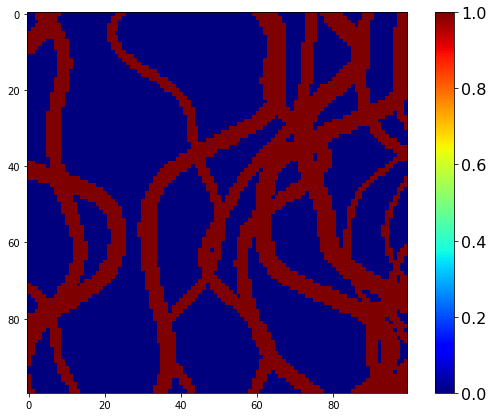

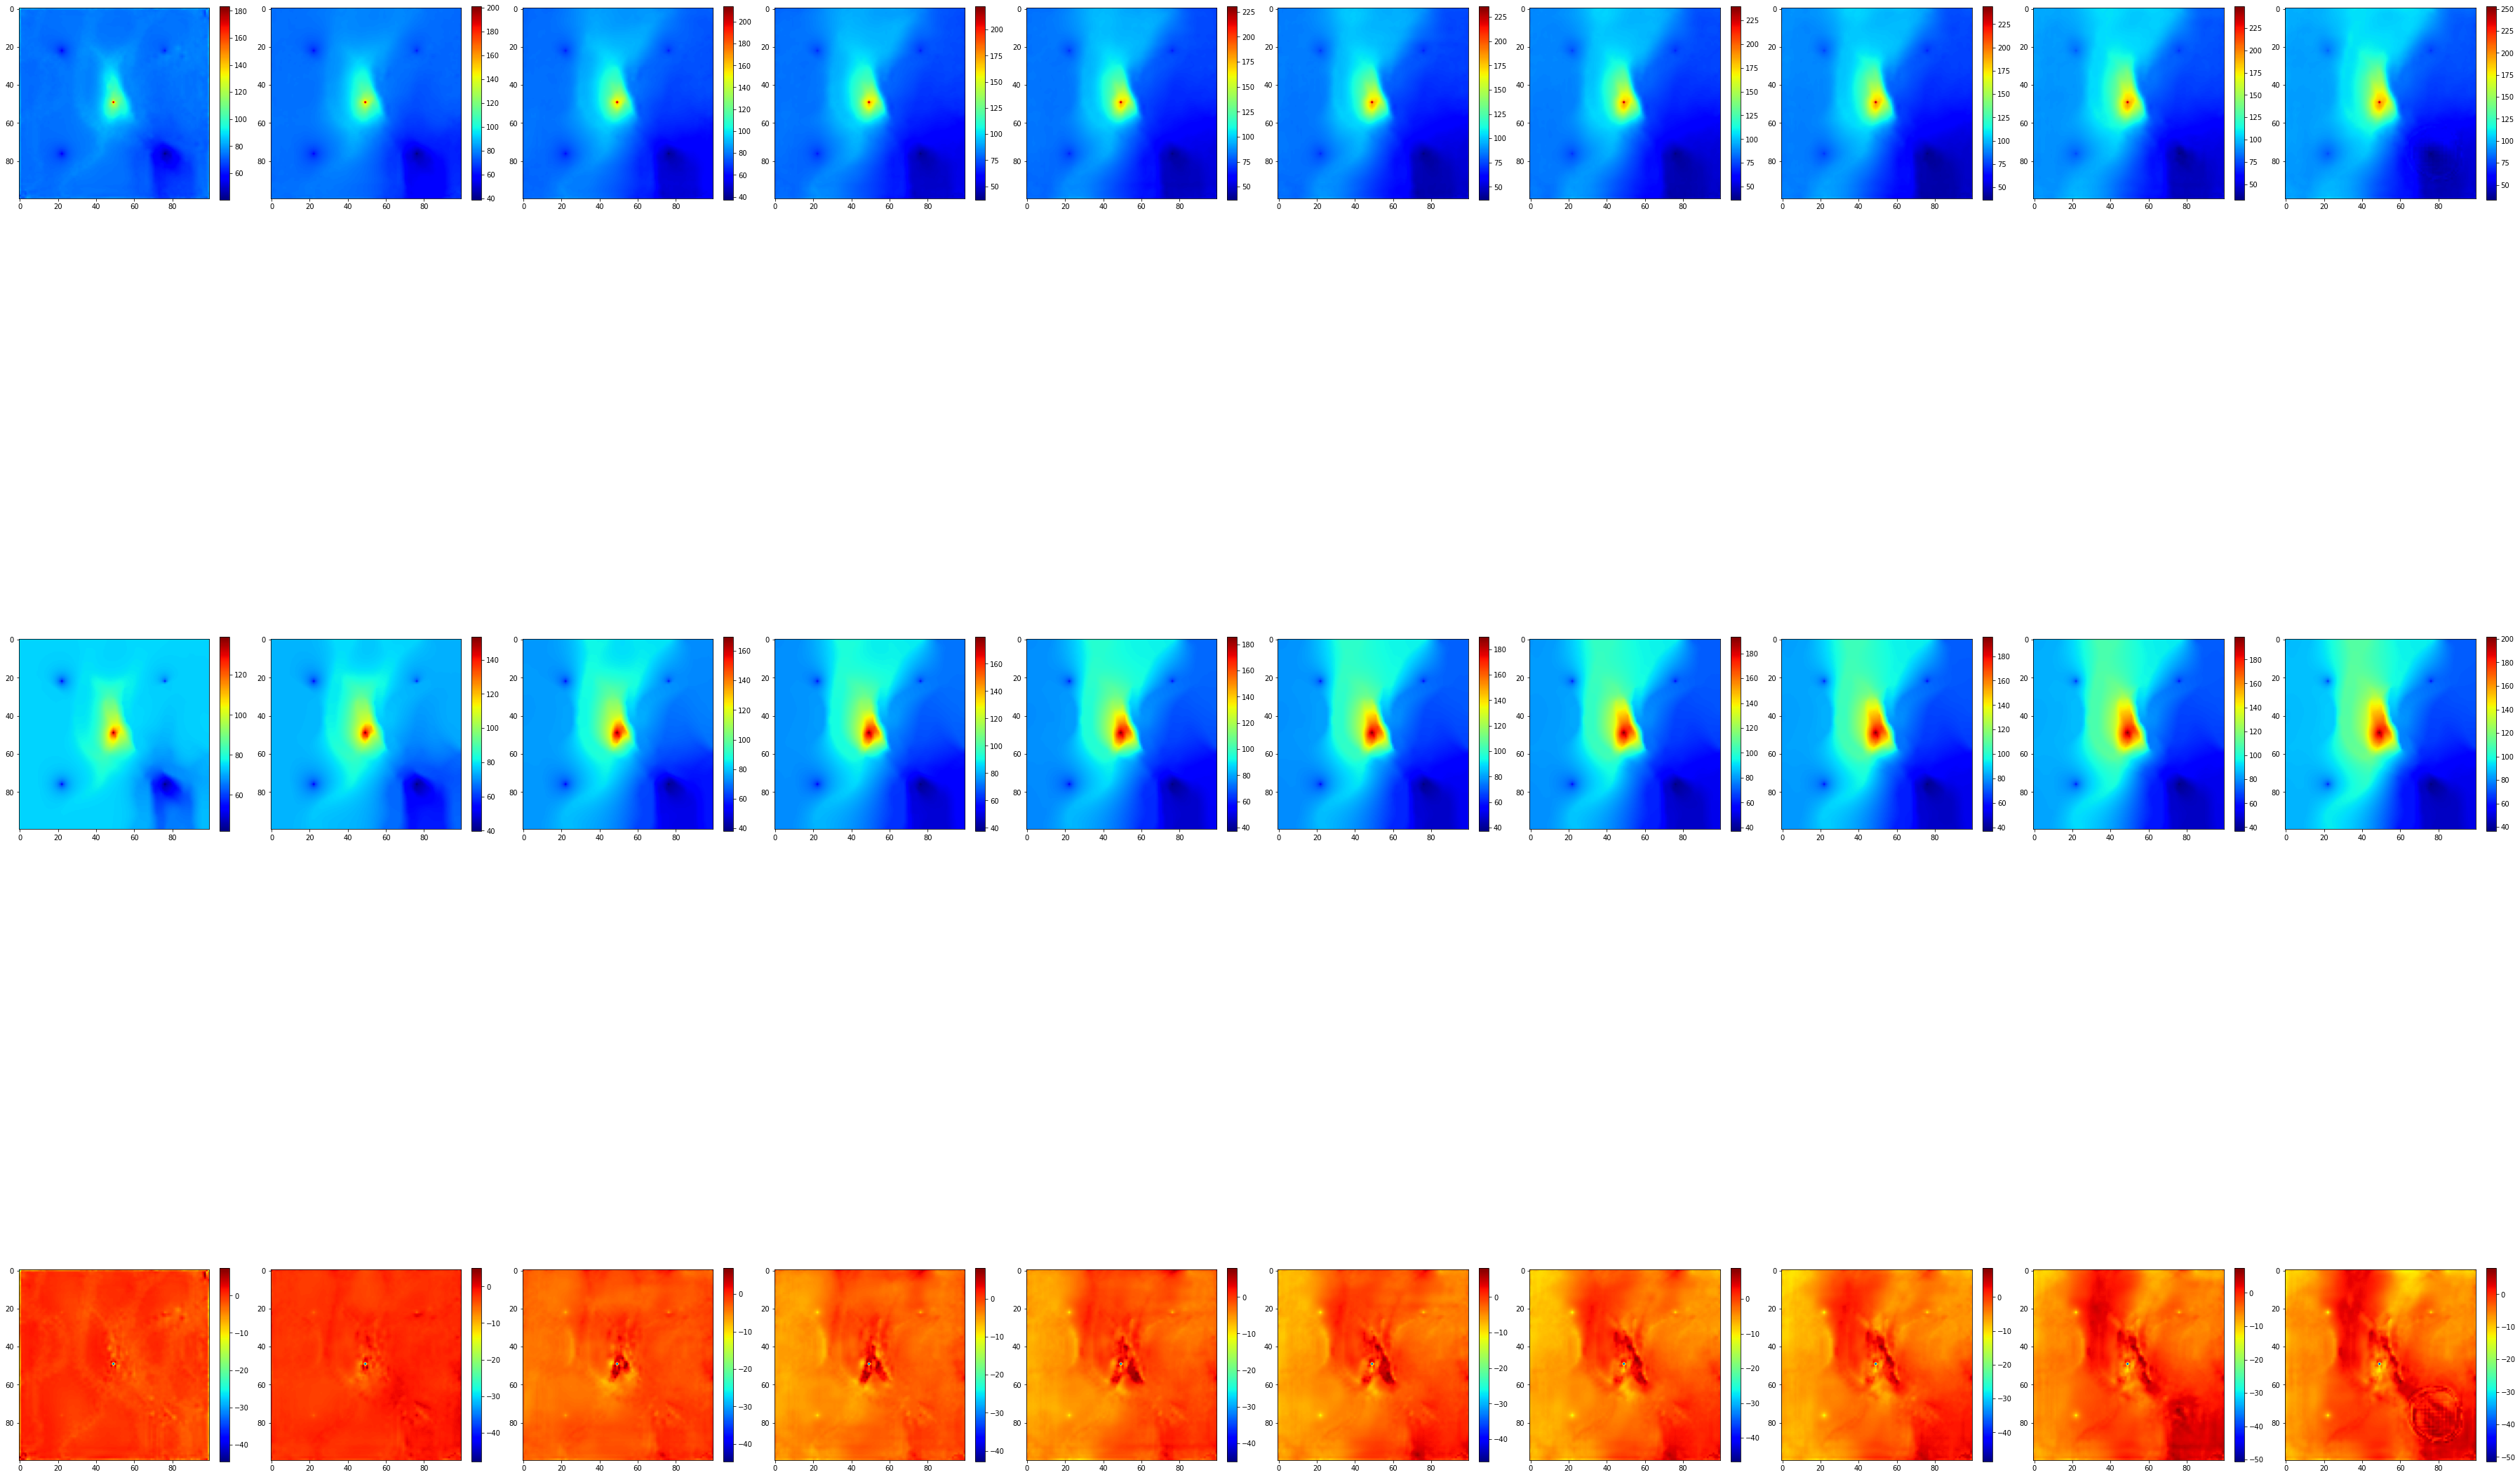

In [22]:
k = 100
plt.figure(figsize=(10,7))
# True permeability
plt.imshow(test_x[k, ::-1, :, 0])
cbar = plt.colorbar(fraction=0.046)
cbar.ax.tick_params(labelsize=16)
#plt.imshow(test_x[k, ::-1, :, 0].reshape((100,100)), vmin=-0.09, vmax=1.07)
#plt.set_clim([-0.09, 1.07])
plt.figure(figsize=(50,50))
for i_tstep in range(depth):
    plt.subplot(3, depth, i_tstep+1)
    
    plt.imshow(p_pred[k, i_tstep, :, :])
    plt.colorbar(fraction=0.046)
    plt.subplot(3, depth, i_tstep+1+depth)
    plt.imshow(p_true[k, i_tstep, :, :].reshape((100,100)))
    plt.colorbar(fraction=0.046)
    
    plt.subplot(3, depth, i_tstep+1+2*depth)
    plt.imshow(p_true[k, i_tstep, :, :].reshape((100,100)) - p_pred[k, i_tstep, :, :])
    plt.colorbar(fraction=0.046)
    #plt.clim([-0.2, 0.2])
    plt.tight_layout()

plt.show()